In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
matplotlib.use('Agg')
from sklearn import svm, cross_validation
import pylab as pl
from PIL import Image
import numpy as np
import os
# Make sure that caffe is on the python path:
caffe_root = '/u/zexuan/caffe/caffe/'  # this file is expected to be in {caffe_root}/examples
caffe_real_root = '/pkgs/caffe/'
thesis_root = '/ais/gobi2/pingpong/thesis/'
#!ls /pkgs/caffe
import sys
sys.path.insert(0, caffe_real_root + 'python')
import caffe

/usr/lib/pymodules/python2.7/matplotlib/__init__.py:1173: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [ ]:
# Download the caffenet model to models/bvlc_reference_caffenet directory
!/u/zexuan/caffe/caffe/data/ilsvrc12/get_ilsvrc_aux.sh
if not os.path.isfile('/u/zexuan/caffe/caffe/models/bvlc_reference_caffenet/bvlc_reference_caffenet.caffemodel'):
    print("Downloading pre-trained CaffeNet model...")
    !~/caffe/caffe/scripts/download_model_binary.py ~/caffe/caffe/models/bvlc_reference_caffenet

In [ ]:
# Download training data into data/flickr_style directory and labels into train.txt and test.txt
!python ~/caffe/caffe/examples/finetune_flickr_style/assemble_data.py \
    --workers=-1 --images=2000 --seed=1701 --label=5

In [2]:
#For your record, if you want to train the network in pure C++ tools, here is the command:
# build/tools/caffe train \
#     -solver models/finetune_flickr_style/solver.prototxt \
#     -weights models/bvlc_reference_caffenet/bvlc_reference_caffenet.caffemodel \
#     -gpu 0

niter = 100
# losses will also be stored in the log
train_loss = np.zeros(niter)
scratch_train_loss = np.zeros(niter)

caffe.set_device(0)
caffe.set_mode_gpu()
#caffe.set_mode_cpu()


In [3]:
# We create a solver that fine-tunes from a previously trained network.
solver = caffe.SGDSolver('/u/zexuan/caffe/caffe/models/finetune_flickr_style/solver.prototxt')
solver.net.copy_from('/u/zexuan/caffe/caffe/models/bvlc_reference_caffenet/bvlc_reference_caffenet.caffemodel')
# For reference, we also create a solver that does no finetuning.
scratch_solver = caffe.SGDSolver('/u/zexuan/caffe/caffe/models/finetune_flickr_style/solver.prototxt')

# We run the solver for niter times, and record the training loss.

for it in range(niter):
    solver.step(1)  # SGD by Caffe
    scratch_solver.step(1)
    # store the train loss
    train_loss[it] = solver.net.blobs['loss'].data
    scratch_train_loss[it] = scratch_solver.net.blobs['loss'].data
    if it % 10 == 0:
        print 'iter %d, finetune_loss=%f, scratch_loss=%f' % (it, train_loss[it], scratch_train_loss[it])
print 'done'

iter 0, finetune_loss=3.543135, scratch_loss=3.489816
iter 10, finetune_loss=3.110996, scratch_loss=6.110014
iter 20, finetune_loss=1.847101, scratch_loss=2.163922
iter 30, finetune_loss=1.803339, scratch_loss=1.646827
iter 40, finetune_loss=1.547783, scratch_loss=1.904775
iter 50, finetune_loss=1.595848, scratch_loss=1.844910
iter 60, finetune_loss=1.408899, scratch_loss=1.918723
iter 70, finetune_loss=1.668886, scratch_loss=1.751976
iter 80, finetune_loss=1.124534, scratch_loss=1.539874
iter 90, finetune_loss=1.422142, scratch_loss=1.950910
done


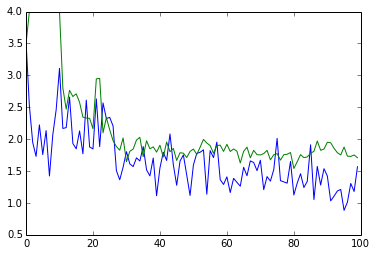

In [9]:
pl.plot(np.vstack([train_loss, scratch_train_loss]).clip(0, 4).T)

In [15]:
test_iters = 10
accuracy = 0
scratch_accuracy = 0
for it in np.arange(test_iters):
    #solver.test_nets[0].forward()
    solver.net.forward()
    accuracy += solver.test_nets[0].blobs['accuracy'].data
    #scratch_solver.test_nets[0].forward()
    scratch_solver.net.forward()
    scratch_accuracy += scratch_solver.test_nets[0].blobs['accuracy'].data
accuracy /= test_iters
scratch_accuracy /= test_iters
print 'Accuracy for fine-tuning:', accuracy
print 'Accuracy for training from scratch:', scratch_accuracy

Accuracy for fine-tuning: 0.379999995232
Accuracy for training from scratch: 0.180000007153


In [25]:
#dir(solver.test_nets[1])
solver.net.save('fine_tune_flicker.caffemodel')
solver.test_nets[0].save('fine_tune_flicker_testnet.caffemodel')